# Load Image

In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
from PIL import Image
%matplotlib inline
import os
import time
import cv2
import glob
import random

from keras.preprocessing import image

from keras.applications import vgg16 
from keras import models, layers, optimizers
from tensorflow.keras.optimizers import RMSprop

seed = 10
random.seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d choerulafifanto/apimembara
!mkdir fireforest

100% 1.47G/1.47G [00:09<00:00, 186MB/s]
100% 1.47G/1.47G [00:09<00:00, 165MB/s]


In [ ]:
! unzip apimembara.zip -d fireforest

Streaming output truncated to the last 5000 lines.
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7758.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7759.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame776.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7760.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7761.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7762.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7763.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7764.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7765.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7766.jpg  
  inflating: fireforest/Training/Training/No_Fire/lake_resized_lake_frame7767.jpg  
  inflating: fireforest/Tr

# Image Description

In [ ]:
train_fire_img = glob.glob('/content/fireforest/Training/Training/Fire/*.jpg')
train_nofire_img = glob.glob('/content/fireforest/Training/Training/No_Fire/*.jpg')

print("Total number of training fire images: ", len(train_fire_img))
print("Total number of training no fire images: ", len(train_nofire_img))

# make train_image_names as serie object
train_fire_img = pd.Series(train_fire_img)
train_nofire_img = pd.Series(train_nofire_img)

train_img = train_fire_img.append(train_nofire_img)
train_img = train_img.sample(frac=1).reset_index(drop=True) # shuffling

print("Total number of training images: ", len(train_img))

Total number of training fire images:  25018
Total number of training no fire images:  14357
Total number of training images:  39375


In [ ]:
test_fire_img = glob.glob('/content/fireforest/Test/Test/Fire/*.jpg')
test_nofire_img = glob.glob('/content/fireforest/Test/Test/No_Fire/*.jpg')

print("Total number of test fire images: ", len(test_fire_img))
print("Total number of test no fire images: ", len(test_nofire_img))

# make train_image_names as serie object
test_fire_img = pd.Series(test_fire_img)
test_nofire_img = pd.Series(test_nofire_img)

test_img = test_fire_img.append(test_nofire_img)
test_img = test_img.sample(frac=1).reset_index(drop=True) # shuffling

print("Total number of test images: ", len(test_img))

Total number of test fire images:  5137
Total number of test no fire images:  3480
Total number of test images:  8617


In [ ]:
masked_img = glob.glob('/content/fireforest/Masks/Masks/*.png')
print("Total number of masked images: ", len(masked_img))

masked_img = pd.Series(masked_img)

Total number of masked images:  2003


In [ ]:
# train_df: a dataframe with 2 field: filename, label

train_df = pd.DataFrame()

# generate Filename field
train_df['filename'] = train_img.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['label'] = train_img.map(lambda img_name: int(1) if img_name.split("/")[-2] == 'Fire' else int(0))

train_df.tail()

,filename,label
39370,resized_frame16247.jpg,1
39371,resized_frame26424.jpg,1
39372,lake_resized_lake_frame9895.jpg,0
39373,lake_resized_lake_frame11177.jpg,0
39374,resized_frame13735.jpg,1


In [ ]:
# test_df: a dataframe with 2 field: filename, label

test_df = pd.DataFrame()

# generate Filename field
test_df['filename'] = test_img.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
test_df['label'] = test_img.map(lambda img_name: int(1) if img_name.split("/")[-2] == 'Fire' else int(0))

test_df.tail()

,filename,label
8612,resized_test_fire_frame2414.jpg,1
8613,resized_test_nofire_frame128.jpg,0
8614,resized_test_fire_frame912.jpg,1
8615,resized_test_fire_frame3171.jpg,1
8616,resized_test_nofire_frame922.jpg,0


In [ ]:
class_id_distribution = train_df['label'].value_counts()
print(class_id_distribution)

1    25018
0    14357
Name: label, dtype: int64


# Modeling

In [ ]:
train_dir = '/content/fireforest/Training/Training'
test_dir = '/content/fireforest/Test/Test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.3)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (254, 254),
                                                    subset='training')  

val_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (254, 254),
                                                  subset='validation') 


Found 27563 images belonging to 2 classes.
Found 11812 images belonging to 2 classes.


In [ ]:
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(254, 254, 3))
vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 254, 254, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 254, 254, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                              

In [ ]:
# freeze the layers except the last 4 layers
for layer in vgg_model.layers[:-4]:
    layer.trainable = False
    
# check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4c34302950> False
<keras.layers.convolutional.Conv2D object at 0x7f4c3120b850> False
<keras.layers.convolutional.Conv2D object at 0x7f4c300a5e90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4c308bc3d0> False
<keras.layers.convolutional.Conv2D object at 0x7f4c3042bf10> False
<keras.layers.convolutional.Conv2D object at 0x7f4c304323d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4c3043c910> False
<keras.layers.convolutional.Conv2D object at 0x7f4c30432210> False
<keras.layers.convolutional.Conv2D object at 0x7f4c300a5850> False
<keras.layers.convolutional.Conv2D object at 0x7f4c3044e190> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4c30453f10> False
<keras.layers.convolutional.Conv2D object at 0x7f4c3044a450> False
<keras.layers.convolutional.Conv2D object at 0x7f4c3045ab50> False
<keras.layers.convolutional.Conv2D object at 0x7f4c303e4310> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4c303dee10>

In [ ]:
# add the VGG convolutional base model
model = models.Sequential()
model.add(vgg_model)

# add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# show a summary of the model and check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 40,406,849
Trainable params: 32,771,585
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
%%time
# Train the model.
history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 52s - loss: 0.0689 - accuracy: 0.9790 - val_loss: 0.3419 - val_accuracy: 0.9070 - 52s/epoch - 520ms/step
Epoch 2/20
100/100 - 52s - loss: 0.1191 - accuracy: 0.9720 - val_loss: 0.2767 - val_accuracy: 0.9740 - 52s/epoch - 524ms/step
Epoch 3/20
100/100 - 51s - loss: 0.0857 - accuracy: 0.9845 - val_loss: 0.3345 - val_accuracy: 0.9280 - 51s/epoch - 513ms/step
Epoch 4/20
100/100 - 52s - loss: 0.0957 - accuracy: 0.9840 - val_loss: 0.1104 - val_accuracy: 0.9820 - 52s/epoch - 520ms/step
Epoch 5/20
100/100 - 51s - loss: 0.0655 - accuracy: 0.9855 - val_loss: 0.0509 - val_accuracy: 0.9860 - 51s/epoch - 512ms/step
Epoch 6/20
100/100 - 51s - loss: 0.0833 - accuracy: 0.9860 - val_loss: 0.2970 - val_accuracy: 0.9670 - 51s/epoch - 505ms/step
Epoch 7/20
100/100 - 52s - loss: 0.0825 - accuracy: 0.9835 - val_loss: 0.5163 - val_accuracy: 0.9620 - 52s/epoch - 515ms/step
Epoch 8/20
100/100 - 51s - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.4455 - val_accuracy: 0.9680 - 51s/epoch - 507

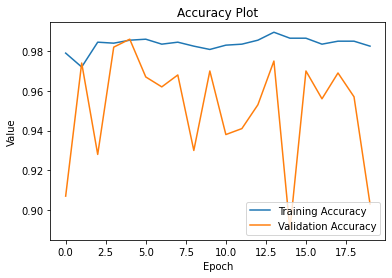

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

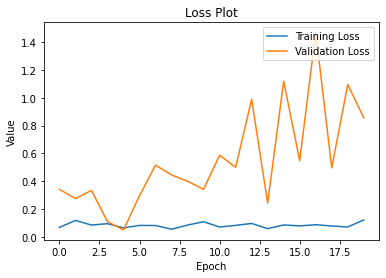

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

# Testing

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

test_generator = test_datagen.flow_from_directory(test_dir,target_size = (254, 254)) 

Found 8617 images belonging to 2 classes.


In [ ]:
%%time
pred = model.predict(test_generator)
filename = pd.DataFrame(test_generator.filenames)[0].apply(lambda x: x.split('/')[1])
pred_df = pd.DataFrame({'filename': filename, 'pred_label': np.around(pred)[:,0]})
pred_df

CPU times: user 1min 20s, sys: 1.18 s, total: 1min 22s
Wall time: 59.6 s


,filename,pred_label
0,resized_test_fire_frame0.jpg,0.0
1,resized_test_fire_frame1.jpg,0.0
2,resized_test_fire_frame10.jpg,1.0
3,resized_test_fire_frame100.jpg,0.0
4,resized_test_fire_frame1000.jpg,0.0
...,...,...
8612,resized_test_nofire_frame995.jpg,0.0
8613,resized_test_nofire_frame996.jpg,0.0
8614,resized_test_nofire_frame997.jpg,1.0
8615,resized_test_nofire_frame998.jpg,0.0


In [ ]:
test_df['label'] = test_df['label'].astype('float')
merge_df = pd.merge(pred_df,test_df,on='filename')
merge_df

,filename,pred_label,label
0,resized_test_fire_frame0.jpg,0.0,1.0
1,resized_test_fire_frame1.jpg,0.0,1.0
2,resized_test_fire_frame10.jpg,1.0,1.0
3,resized_test_fire_frame100.jpg,0.0,1.0
4,resized_test_fire_frame1000.jpg,0.0,1.0
...,...,...,...
8612,resized_test_nofire_frame995.jpg,0.0,0.0
8613,resized_test_nofire_frame996.jpg,0.0,0.0
8614,resized_test_nofire_frame997.jpg,1.0,0.0
8615,resized_test_nofire_frame998.jpg,0.0,0.0


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(merge_df['label'], merge_df['pred_label'], target_names=['No_Fire','Fire']))

              precision    recall  f1-score   support

     No_Fire       0.41      0.52      0.46      3480
        Fire       0.61      0.50      0.55      5137

    accuracy                           0.51      8617
   macro avg       0.51      0.51      0.50      8617
weighted avg       0.53      0.51      0.51      8617



In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(merge_df['label'], merge_df['pred_label'])
import seaborn as sns

cf_matrix

array([[1825, 1655],
       [2582, 2555]])

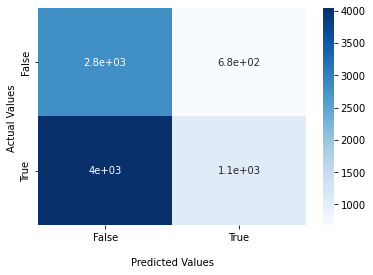

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

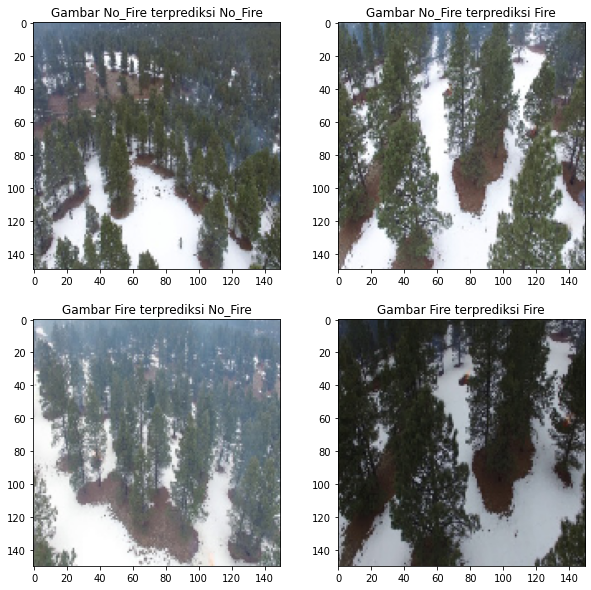

In [ ]:
FF = str(merge_df[(merge_df['pred_label'] == 0) & (merge_df['label'] == 0)]['filename'].sample()).split()[1] #No Fire - No Fire
FT = str(merge_df[(merge_df['pred_label'] == 1) & (merge_df['label'] == 0)]['filename'].sample()).split()[1] #No Fire - Fire
TF = str(merge_df[(merge_df['pred_label'] == 0) & (merge_df['label'] == 1)]['filename'].sample()).split()[1] #Fire - No Fire
TT = str(merge_df[(merge_df['pred_label'] == 1) & (merge_df['label'] == 1)]['filename'].sample()).split()[1] #Fire - Fire

ax = plt.figure(figsize=[10,10])
ax.patch.set_facecolor('white')
plt.subplot(2,2,1)
path = os.path.join( test_dir, 'No_Fire/'+FF)
img = image.load_img(path, target_size =(150,150))
plt.imshow(img)
plt.title('Gambar No_Fire terprediksi No_Fire')

plt.subplot(2,2,2)
path = os.path.join( test_dir, 'No_Fire/'+FT)
img = image.load_img(path, target_size =(150,150))
plt.imshow(img)
plt.title('Gambar No_Fire terprediksi Fire')

plt.subplot(2,2,3)
path = os.path.join( test_dir, 'Fire/'+TF)
img = image.load_img(path, target_size =(150,150))
plt.imshow(img)
plt.title('Gambar Fire terprediksi No_Fire')

plt.subplot(2,2,4)
path = os.path.join( test_dir, 'Fire/'+TT)
img = image.load_img(path, target_size =(150,150))
plt.imshow(img)
plt.title('Gambar Fire terprediksi Fire')

plt.show()